[Baseline linear] train acc: 0.858, test acc: 0.868
[Flow train] epoch 30/150, loss=4.5518
[Flow train] epoch 60/150, loss=4.5505
[Flow train] epoch 90/150, loss=4.5487
[Flow train] epoch 120/150, loss=4.5488
[Flow train] epoch 150/150, loss=4.5482
Finished training vector field.
[Flow + linear] train acc: 1.000, test acc: 1.000


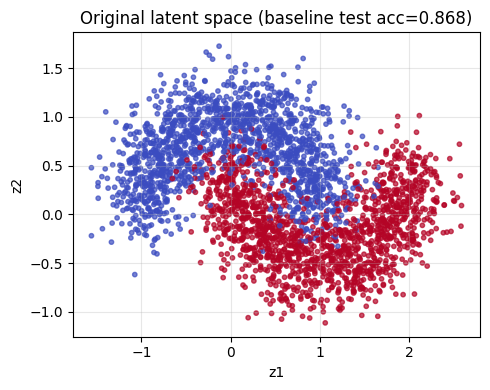

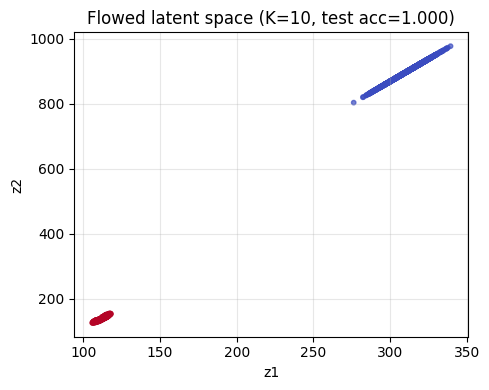

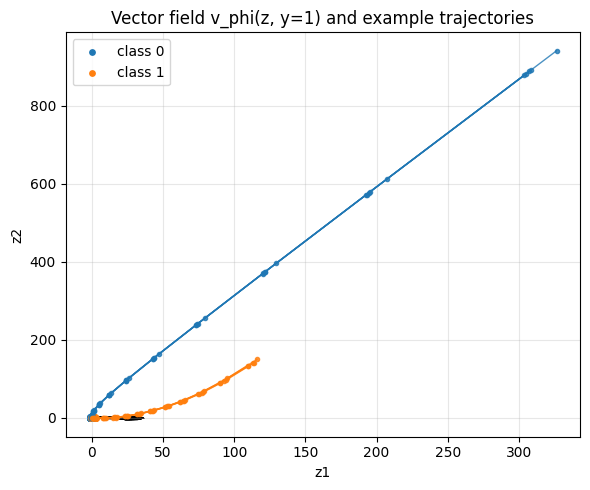

In [ ]:
# ============================
# Colab-ready latent flow demo
# ============================

!pip install -q scikit-learn matplotlib

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# Make plots inline
%matplotlib inline

# ----------------------------
# 0. Basic config
# ----------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(0)
torch.manual_seed(0)

LATENT_DIM = 2          # keep latent 2-D for easy visualization
NUM_CLASSES = 2
TRAIN_SAMPLES = 3000
TEST_SAMPLES = 1000
BATCH_SIZE = 256
VECTOR_FIELD_HIDDEN = 128
EPOCHS_FLOW = 150       # you can bump up if you want
EPOCHS_BASELINE = 150
EPS_TRAIN = 0.15        # step size during flow training (Euler step)
EPS_EVAL = 0.15         # step size during evaluation
K_STEPS_EVAL = 10       # number of flow steps at evaluation
TAU = 0.1               # temperature for supervised contrastive loss
LR_FLOW = 1e-3
LR_CLS = 5e-3
LAMBDA_CURL = 1e-2
LAMBDA_DIV = 1e-2


# ----------------------------
# 1. Data: 2D two moons
# ----------------------------

def build_moons(n_samples, noise=0.2):
    X, y = make_moons(n_samples=n_samples, noise=noise)
    X = X.astype(np.float32)
    y = y.astype(np.int64)
    return X, y

X_train_np, y_train_np = build_moons(TRAIN_SAMPLES, noise=0.25)
X_test_np,  y_test_np  = build_moons(TEST_SAMPLES,  noise=0.25)

# frozen encoder is identity: z = f(x)
z_train_np = X_train_np.copy()
z_test_np  = X_test_np.copy()

z_train = torch.from_numpy(z_train_np).to(device)
z_test  = torch.from_numpy(z_test_np).to(device)
y_train = torch.from_numpy(y_train_np).to(device)
y_test  = torch.from_numpy(y_test_np).to(device)

train_loader = DataLoader(
    TensorDataset(z_train, y_train),
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)
test_loader = DataLoader(
    TensorDataset(z_test, y_test),
    batch_size=BATCH_SIZE,
    shuffle=False,
)


# ----------------------------
# 2. Baseline: linear classifier on z
# ----------------------------

class LinearClassifier(nn.Module):
    def __init__(self, dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(dim, num_classes)

    def forward(self, z):
        return self.fc(z)


def train_linear_classifier(z_train, y_train, z_test, y_test):
    model = LinearClassifier(LATENT_DIM, NUM_CLASSES).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=LR_CLS)

    dataset = TensorDataset(z_train, y_train)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    for epoch in range(EPOCHS_BASELINE):
        model.train()
        for z_batch, y_batch in loader:
            logits = model(z_batch)
            loss = F.cross_entropy(logits, y_batch)
            opt.zero_grad()
            loss.backward()
            opt.step()

    @torch.no_grad()
    def eval_acc(z, y):
        model.eval()
        logits = model(z)
        preds = logits.argmax(dim=1)
        acc = (preds == y).float().mean().item()
        return acc

    train_acc = eval_acc(z_train, y_train)
    test_acc = eval_acc(z_test, y_test)
    return model, train_acc, test_acc


baseline_model, base_train_acc, base_test_acc = train_linear_classifier(
    z_train, y_train, z_test, y_test
)

print(f"[Baseline linear] train acc: {base_train_acc:.3f}, test acc: {base_test_acc:.3f}")


# ----------------------------
# 3. Vector field model v_phi(z, y)
# ----------------------------

class VectorField(nn.Module):
    """
    v_phi(z, y) : R^d x {0,...,C-1} -> R^d
    Implemented as:
        y_embed -> e_y (learned embedding)
        concat [z, e_y] -> MLP -> v
    """
    def __init__(self, dim, num_classes, hidden=128, embed_dim=16):
        super().__init__()
        self.class_emb = nn.Embedding(num_classes, embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim + embed_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, dim),
        )

    def forward(self, z, y):
        e = self.class_emb(y)
        inp = torch.cat([z, e], dim=1)
        v = self.mlp(inp)
        return v


vf = VectorField(LATENT_DIM, NUM_CLASSES, hidden=VECTOR_FIELD_HIDDEN).to(device)
opt_vf = torch.optim.Adam(vf.parameters(), lr=LR_FLOW)


# ----------------------------
# 4. Losses: supervised contrastive + curl/div
# ----------------------------

def supervised_contrastive_loss(z, y, temperature=0.1):
    """
    z: [B, d] latent representations (after flow step)
    y: [B] labels
    Implements supervised contrastive loss (Khosla et al. 2020).
    """
    z = F.normalize(z, dim=1)
    B = z.size(0)

    # similarity matrix
    sim = torch.matmul(z, z.t()) / temperature  # [B,B]

    # mask to exclude self-comparisons
    logits_mask = torch.ones_like(sim) - torch.eye(B, device=sim.device)
    sim = sim * logits_mask

    # positive mask: same label
    y_i = y.unsqueeze(1)
    y_j = y.unsqueeze(0)
    pos_mask = (y_i == y_j).float() * logits_mask  # [B,B]

    # log prob of j given i
    exp_sim = torch.exp(sim) * logits_mask
    log_prob = sim - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-8)

    # mean log-prob over positive pairs for each i
    pos_count = pos_mask.sum(dim=1)
    mean_log_prob_pos = (pos_mask * log_prob).sum(dim=1) / (pos_count + 1e-8)

    loss = -mean_log_prob_pos.mean()
    return loss


def curl_and_divergence_regularizers(z, y, vf):
    """
    In 2-D:
        v = (v1, v2)
        curl = dv2/dz1 - dv1/dz2  (scalar per sample)
        div  = dv1/dz1 + dv2/dz2

    We compute them via autograd.
    """
    z = z.clone().detach().requires_grad_(True)
    v = vf(z, y)  # [B,2]
    v1 = v[:, 0]
    v2 = v[:, 1]

    # gradients of v1 and v2 w.r.t z
    grads_v1 = torch.autograd.grad(v1.sum(), z, create_graph=True)[0]  # [B,2]
    grads_v2 = torch.autograd.grad(v2.sum(), z, create_graph=True)[0]  # [B,2]

    dv1_dz1 = grads_v1[:, 0]
    dv1_dz2 = grads_v1[:, 1]
    dv2_dz1 = grads_v2[:, 0]
    dv2_dz2 = grads_v2[:, 1]

    curl = dv2_dz1 - dv1_dz2    # [B]
    div = dv1_dz1 + dv2_dz2     # [B]

    L_curl = (curl ** 2).mean()
    L_div = (div ** 2).mean()
    return L_curl, L_div


# ----------------------------
# 5. Train the vector field
# ----------------------------

for epoch in range(EPOCHS_FLOW):
    vf.train()
    total_loss = 0.0

    for z_batch, y_batch in train_loader:
        # one Euler step
        v = vf(z_batch, y_batch)
        z_tilde = z_batch + EPS_TRAIN * v

        L_con = supervised_contrastive_loss(z_tilde, y_batch, temperature=TAU)
        L_curl, L_div = curl_and_divergence_regularizers(z_batch, y_batch, vf)

        loss = L_con + LAMBDA_CURL * L_curl + LAMBDA_DIV * L_div

        opt_vf.zero_grad()
        loss.backward()
        opt_vf.step()

        total_loss += loss.item() * z_batch.size(0)

    if (epoch + 1) % 30 == 0:
        avg_loss = total_loss / (len(train_loader.dataset))
        print(f"[Flow train] epoch {epoch+1}/{EPOCHS_FLOW}, loss={avg_loss:.4f}")

print("Finished training vector field.")


# ----------------------------
# 6. Apply K-step flow and train classifier on flowed embeddings
# ----------------------------

@torch.no_grad()
def apply_flow(z, y, K=K_STEPS_EVAL, eps=EPS_EVAL):
    z_flow = z.clone()
    for _ in range(K):
        v = vf(z_flow, y)
        z_flow = z_flow + eps * v
    return z_flow


z_train_flow = apply_flow(z_train, y_train, K=K_STEPS_EVAL, eps=EPS_EVAL)
z_test_flow  = apply_flow(z_test,  y_test,  K=K_STEPS_EVAL, eps=EPS_EVAL)

flow_cls, flow_train_acc, flow_test_acc = train_linear_classifier(
    z_train_flow, y_train, z_test_flow, y_test
)

print(f"[Flow + linear] train acc: {flow_train_acc:.3f}, test acc: {flow_test_acc:.3f}")


# ----------------------------
# 7. Plotting utilities
# ----------------------------

def plot_latent(z, y, title):
    z_np = z.detach().cpu().numpy()
    y_np = y.detach().cpu().numpy()
    plt.figure(figsize=(5, 4))
    plt.scatter(z_np[:, 0], z_np[:, 1], c=y_np, cmap="coolwarm", s=10, alpha=0.7)
    plt.title(title)
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_vector_field_and_trajectories(z, y):
    # subsample for clarity
    idx = torch.randperm(z.size(0))[:400]
    z_sub = z[idx]
    y_sub = y[idx]

    z_np = z_sub.cpu().numpy()
    y_np = y_sub.cpu().numpy()

    # grid
    x_min, x_max = z_np[:, 0].min() - 0.5, z_np[:, 0].max() + 0.5
    y_min, y_max = z_np[:, 1].min() - 0.5, z_np[:, 1].max() + 0.5

    gx, gy = np.meshgrid(
        np.linspace(x_min, x_max, 25),
        np.linspace(y_min, y_max, 25),
    )
    grid = np.stack([gx, gy], axis=-1).reshape(-1, 2)
    grid_t = torch.from_numpy(grid.astype(np.float32)).to(device)

    # pick one target label (class 1)
    y_target = torch.ones(grid_t.size(0), dtype=torch.long, device=device)
    with torch.no_grad():
        v_grid = vf(grid_t, y_target).cpu().numpy()

    # plot
    plt.figure(figsize=(6, 5))
    plt.quiver(
        grid[:, 0],
        grid[:, 1],
        v_grid[:, 0],
        v_grid[:, 1],
        alpha=0.4,
        angles="xy",
        scale_units="xy",
        scale=1.5,
    )

    # scatter points colored by label
    plt.scatter(
        z_np[y_np == 0, 0],
        z_np[y_np == 0, 1],
        c="tab:blue",
        label="class 0",
        s=15,
    )
    plt.scatter(
        z_np[y_np == 1, 0],
        z_np[y_np == 1, 1],
        c="tab:orange",
        label="class 1",
        s=15,
    )

    # example trajectories: pick a few points from each class, flow them
    for c, color in [(0, "tab:blue"), (1, "tab:orange")]:
        idx_c = np.where(y_np == c)[0]
        np.random.shuffle(idx_c)
        idx_c = idx_c[:5]
        for i in idx_c:
            z0 = torch.from_numpy(z_np[i:i+1]).to(device)
            y0 = torch.tensor([c], dtype=torch.long, device=device)
            traj = [z0.cpu().numpy()[0]]
            with torch.no_grad():
                z_cur = z0
                for _ in range(10):
                    v = vf(z_cur, y0)
                    z_cur = z_cur + EPS_EVAL * v
                    traj.append(z_cur.cpu().numpy()[0])
            traj = np.stack(traj, axis=0)
            plt.plot(
                traj[:, 0],
                traj[:, 1],
                "-o",
                markersize=3,
                linewidth=1,
                color=color,
                alpha=0.8,
            )

    plt.title("Vector field v_phi(z, y=1) and example trajectories")
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# ----------------------------
# 8. Show figures
# ----------------------------

plot_latent(z_train, y_train,
            f"Original latent space (baseline test acc={base_test_acc:.3f})")

plot_latent(z_train_flow, y_train,
            f"Flowed latent space (K={K_STEPS_EVAL}, test acc={flow_test_acc:.3f})")

plot_vector_field_and_trajectories(z_train, y_train)


In [ ]:
def plot_attribute_edit_flow(z, y, source_class=0, target_class=1, K=10, eps=EPS_EVAL):
    """
    Show how points from source_class move when we ask the vector field
    to make them look like target_class.

    Analogy: source_class=0 -> 'no smile', target_class=1 -> 'smile'.
    """
    z_np = z.detach().cpu().numpy()
    y_np = y.detach().cpu().numpy()

    # scatter everything in background
    plt.figure(figsize=(6, 5))
    plt.scatter(
        z_np[y_np == 0, 0],
        z_np[y_np == 0, 1],
        c="tab:blue",
        label="class 0 (no smile)",
        s=15,
        alpha=0.4,
    )
    plt.scatter(
        z_np[y_np == 1, 0],
        z_np[y_np == 1, 1],
        c="tab:orange",
        label="class 1 (smile)",
        s=15,
        alpha=0.4,
    )

    # pick a few starting points from source_class
    idx_src = np.where(y_np == source_class)[0]
    np.random.shuffle(idx_src)
    idx_src = idx_src[:8]   # 8 trajectories for clarity

    for i in idx_src:
        z0 = torch.from_numpy(z_np[i:i+1]).to(device)
        # IMPORTANT: we fix the target label for the whole trajectory
        y_target = torch.full((1,), target_class, dtype=torch.long, device=device)

        traj = [z0.cpu().numpy()[0]]
        with torch.no_grad():
            z_cur = z0
            for _ in range(K):
                v = vf(z_cur, y_target)
                z_cur = z_cur + eps * v
                traj.append(z_cur.cpu().numpy()[0])
        traj = np.stack(traj, axis=0)

        plt.plot(
            traj[:, 0],
            traj[:, 1],
            "-o",
            markersize=3,
            linewidth=1,
            color="k",
        )

        plt.annotate(
            "",
            xy=traj[-1],
            xytext=traj[0],
            arrowprops=dict(arrowstyle="->", color="k", lw=1),
        )

    plt.title(f"Attribute-edit flow: class {source_class} → class {target_class}")
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


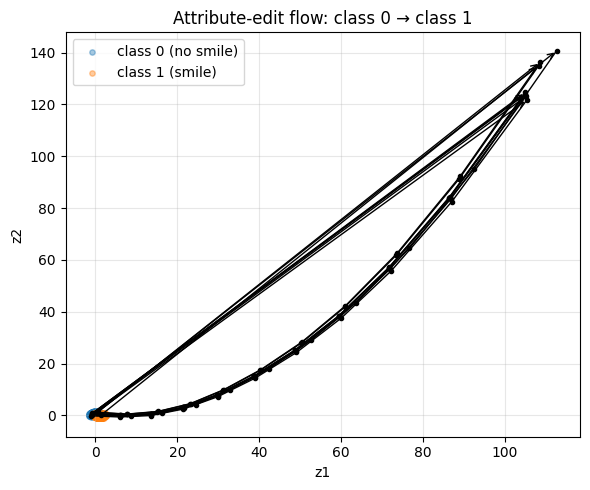

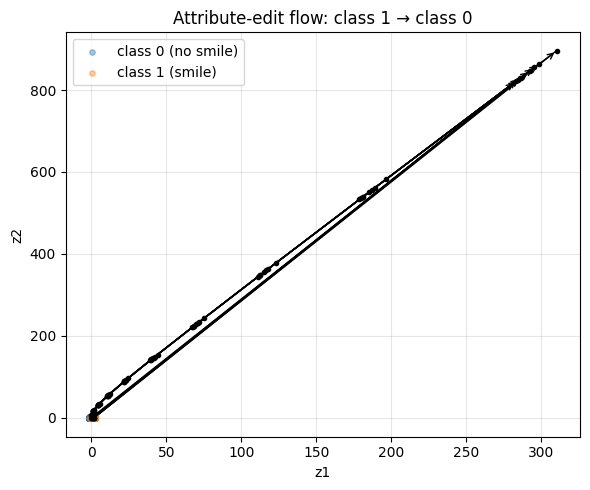

In [ ]:
# Attribute-edit style flow: "no smile" (0) -> "smile" (1)
plot_attribute_edit_flow(z_train, y_train, source_class=0, target_class=1, K=10)

# If you want the reverse ("remove smile"):
plot_attribute_edit_flow(z_train, y_train, source_class=1, target_class=0, K=10)

[Baseline linear] train acc: 0.858, test acc: 0.868
[Flow train] epoch 30/150, loss=4.5518
[Flow train] epoch 60/150, loss=4.5505
[Flow train] epoch 90/150, loss=4.5488
[Flow train] epoch 120/150, loss=4.5488
[Flow train] epoch 150/150, loss=4.5482
Finished training vector field.
[Flow + linear] train acc: 1.000, test acc: 1.000


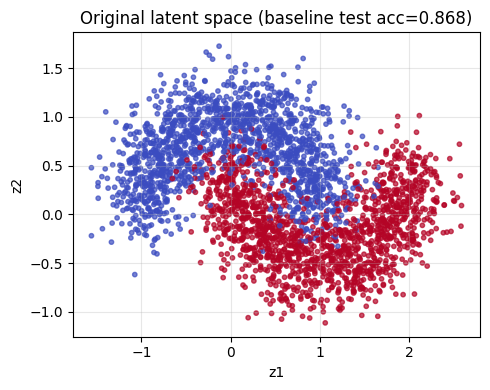

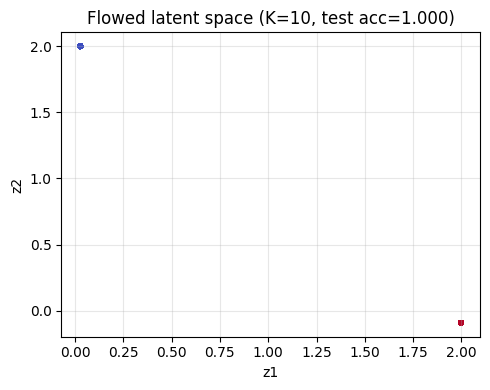

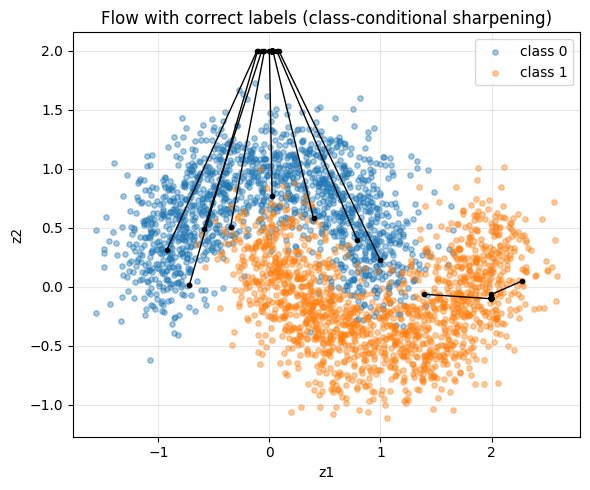

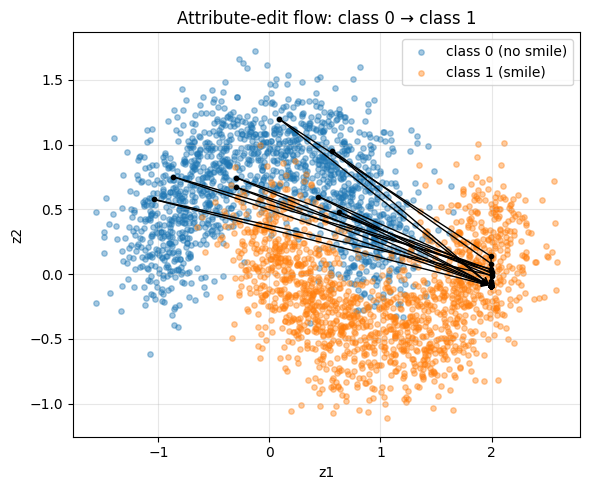

In [ ]:
# ==========================================
# Colab-ready demo: function-aware latent flow
# on 2D two-moons dataset
# ==========================================

!pip install -q scikit-learn matplotlib

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

%matplotlib inline

# ----------------------------
# 0. Basic config
# ----------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(0)
torch.manual_seed(0)

LATENT_DIM = 2
NUM_CLASSES = 2
TRAIN_SAMPLES = 3000
TEST_SAMPLES  = 1000
BATCH_SIZE = 256
VECTOR_FIELD_HIDDEN = 128
EPOCHS_FLOW = 150
EPOCHS_BASELINE = 150
EPS_TRAIN = 0.15
EPS_EVAL  = 0.15
K_STEPS_EVAL = 10
TAU = 0.1          # supervised contrastive temperature
LR_FLOW = 1e-3
LR_CLS  = 5e-3
LAMBDA_CURL = 1e-2
LAMBDA_DIV  = 1e-2
RADIUS = 2.0      # radius for projection to avoid blow-up


# ----------------------------
# 1. Data: 2D two moons
# ----------------------------

def build_moons(n_samples, noise=0.2):
    X, y = make_moons(n_samples=n_samples, noise=noise)
    X = X.astype(np.float32)
    y = y.astype(np.int64)
    return X, y

X_train_np, y_train_np = build_moons(TRAIN_SAMPLES, noise=0.25)
X_test_np,  y_test_np  = build_moons(TEST_SAMPLES,  noise=0.25)

# Frozen encoder is identity: z = f(x)
z_train_np = X_train_np.copy()
z_test_np  = X_test_np.copy()

z_train = torch.from_numpy(z_train_np).to(device)
z_test  = torch.from_numpy(z_test_np).to(device)
y_train = torch.from_numpy(y_train_np).to(device)
y_test  = torch.from_numpy(y_test_np).to(device)

train_loader = DataLoader(
    TensorDataset(z_train, y_train),
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)
test_loader = DataLoader(
    TensorDataset(z_test, y_test),
    batch_size=BATCH_SIZE,
    shuffle=False,
)


# ----------------------------
# 2. Helper: projection to circle
# ----------------------------

def project_to_circle(z, radius=RADIUS):
    """Keep latent points on a circle of given radius (prevents blow-up)."""
    norms = z.norm(dim=1, keepdim=True) + 1e-8
    return radius * z / norms


# ----------------------------
# 3. Baseline: linear classifier on z
# ----------------------------

class LinearClassifier(nn.Module):
    def __init__(self, dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(dim, num_classes)

    def forward(self, z):
        return self.fc(z)


def train_linear_classifier(z_train, y_train, z_test, y_test):
    model = LinearClassifier(LATENT_DIM, NUM_CLASSES).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=LR_CLS)

    dataset = TensorDataset(z_train, y_train)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    for _ in range(EPOCHS_BASELINE):
        model.train()
        for z_batch, y_batch in loader:
            logits = model(z_batch)
            loss = F.cross_entropy(logits, y_batch)
            opt.zero_grad()
            loss.backward()
            opt.step()

    @torch.no_grad()
    def eval_acc(z, y):
        model.eval()
        logits = model(z)
        preds = logits.argmax(dim=1)
        return (preds == y).float().mean().item()

    train_acc = eval_acc(z_train, y_train)
    test_acc  = eval_acc(z_test,  y_test)
    return model, train_acc, test_acc


baseline_model, base_train_acc, base_test_acc = train_linear_classifier(
    z_train, y_train, z_test, y_test
)

print(f"[Baseline linear] train acc: {base_train_acc:.3f}, test acc: {base_test_acc:.3f}")


# ----------------------------
# 4. Vector field v_phi(z, y)
# ----------------------------

class VectorField(nn.Module):
    """
    v_phi(z, y) : R^d x {0,...,C-1} -> R^d
    Implemented as:
        y_embed -> e_y
        concat [z, e_y] -> MLP -> v
    """
    def __init__(self, dim, num_classes, hidden=128, embed_dim=16):
        super().__init__()
        self.class_emb = nn.Embedding(num_classes, embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim + embed_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, dim),
        )

    def forward(self, z, y):
        e = self.class_emb(y)
        inp = torch.cat([z, e], dim=1)
        return self.mlp(inp)


vf = VectorField(LATENT_DIM, NUM_CLASSES, hidden=VECTOR_FIELD_HIDDEN).to(device)
opt_vf = torch.optim.Adam(vf.parameters(), lr=LR_FLOW)


# ----------------------------
# 5. Losses: supervised contrastive + curl/div
# ----------------------------

def supervised_contrastive_loss(z, y, temperature=0.1):
    """
    z: [B, d], after one flow step (we will L2-normalize for the contrastive part)
    y: [B]
    """
    z = F.normalize(z, dim=1)
    B = z.size(0)

    sim = torch.matmul(z, z.t()) / temperature
    logits_mask = torch.ones_like(sim) - torch.eye(B, device=sim.device)
    sim = sim * logits_mask

    y_i = y.unsqueeze(1)
    y_j = y.unsqueeze(0)
    pos_mask = (y_i == y_j).float() * logits_mask

    exp_sim = torch.exp(sim) * logits_mask
    log_prob = sim - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-8)

    pos_count = pos_mask.sum(dim=1)
    mean_log_prob_pos = (pos_mask * log_prob).sum(dim=1) / (pos_count + 1e-8)

    return -mean_log_prob_pos.mean()


def curl_and_divergence_regularizers(z, y, vf):
    """
    In 2D:
        v = (v1, v2)
        curl = dv2/dz1 - dv1/dz2
        div  = dv1/dz1 + dv2/dz2
    """
    z = z.clone().detach().requires_grad_(True)
    v = vf(z, y)
    v1 = v[:, 0]
    v2 = v[:, 1]

    grads_v1 = torch.autograd.grad(v1.sum(), z, create_graph=True)[0]
    grads_v2 = torch.autograd.grad(v2.sum(), z, create_graph=True)[0]

    dv1_dz1 = grads_v1[:, 0]
    dv1_dz2 = grads_v1[:, 1]
    dv2_dz1 = grads_v2[:, 0]
    dv2_dz2 = grads_v2[:, 1]

    curl = dv2_dz1 - dv1_dz2
    div  = dv1_dz1 + dv2_dz2

    L_curl = (curl ** 2).mean()
    L_div  = (div  ** 2).mean()
    return L_curl, L_div


# ----------------------------
# 6. Train the vector field
# ----------------------------

for epoch in range(EPOCHS_FLOW):
    vf.train()
    total_loss = 0.0

    for z_batch, y_batch in train_loader:
        v = vf(z_batch, y_batch)
        z_tilde = z_batch + EPS_TRAIN * v
        z_tilde = project_to_circle(z_tilde, radius=RADIUS)

        L_con = supervised_contrastive_loss(z_tilde, y_batch, temperature=TAU)
        L_curl, L_div = curl_and_divergence_regularizers(z_batch, y_batch, vf)

        loss = L_con + LAMBDA_CURL * L_curl + LAMBDA_DIV * L_div

        opt_vf.zero_grad()
        loss.backward()
        opt_vf.step()

        total_loss += loss.item() * z_batch.size(0)

    if (epoch + 1) % 30 == 0:
        avg_loss = total_loss / len(train_loader.dataset)
        print(f"[Flow train] epoch {epoch+1}/{EPOCHS_FLOW}, loss={avg_loss:.4f}")

print("Finished training vector field.")


# ----------------------------
# 7. Apply K-step flow and train classifier on flowed z
# ----------------------------

@torch.no_grad()
def apply_flow(z, y, K=K_STEPS_EVAL, eps=EPS_EVAL):
    z_flow = z.clone()
    for _ in range(K):
        v = vf(z_flow, y)
        z_flow = z_flow + eps * v
        z_flow = project_to_circle(z_flow, radius=RADIUS)
    return z_flow


z_train_flow = apply_flow(z_train, y_train, K=K_STEPS_EVAL, eps=EPS_EVAL)
z_test_flow  = apply_flow(z_test,  y_test,  K=K_STEPS_EVAL, eps=EPS_EVAL)

flow_cls, flow_train_acc, flow_test_acc = train_linear_classifier(
    z_train_flow, y_train, z_test_flow, y_test
)

print(f"[Flow + linear] train acc: {flow_train_acc:.3f}, test acc: {flow_test_acc:.3f}")


# ----------------------------
# 8. Plotting utilities
# ----------------------------

def plot_latent(z, y, title):
    z_np = z.detach().cpu().numpy()
    y_np = y.detach().cpu().numpy()
    plt.figure(figsize=(5, 4))
    plt.scatter(z_np[:, 0], z_np[:, 1], c=y_np, cmap="coolwarm", s=10, alpha=0.7)
    plt.title(title)
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_correct_label_flow(z, y, K=10, eps=EPS_EVAL):
    """
    Show trajectories when we use the TRUE label as the target
    (class-conditional sharpening).
    """
    z_np = z.detach().cpu().numpy()
    y_np = y.detach().cpu().numpy()

    plt.figure(figsize=(6, 5))
    plt.scatter(
        z_np[y_np == 0, 0], z_np[y_np == 0, 1],
        c="tab:blue", label="class 0", s=15, alpha=0.4,
    )
    plt.scatter(
        z_np[y_np == 1, 0], z_np[y_np == 1, 1],
        c="tab:orange", label="class 1", s=15, alpha=0.4,
    )

    idx = np.random.permutation(len(z_np))[:10]
    for i in idx:
        z0 = torch.from_numpy(z_np[i:i+1]).to(device)
        y0 = torch.tensor([y_np[i]], dtype=torch.long, device=device)

        traj = [z0.cpu().numpy()[0]]
        with torch.no_grad():
            z_cur = z0
            for _ in range(K):
                v = vf(z_cur, y0)
                z_cur = z_cur + eps * v
                z_cur = project_to_circle(z_cur, radius=RADIUS)
                traj.append(z_cur.cpu().numpy()[0])
        traj = np.stack(traj, axis=0)
        plt.plot(traj[:, 0], traj[:, 1], "-o", markersize=3, linewidth=1, color="k")

    plt.title("Flow with correct labels (class-conditional sharpening)")
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_attribute_edit_flow(z, y, source_class=0, target_class=1, K=10, eps=EPS_EVAL):
    """
    Show how points from source_class move when we ask the field
    to make them look like target_class.
    Toy analogue of "no smile" -> "smile".
    """
    z_np = z.detach().cpu().numpy()
    y_np = y.detach().cpu().numpy()

    plt.figure(figsize=(6, 5))
    plt.scatter(
        z_np[y_np == 0, 0], z_np[y_np == 0, 1],
        c="tab:blue", label="class 0 (no smile)", s=15, alpha=0.4,
    )
    plt.scatter(
        z_np[y_np == 1, 0], z_np[y_np == 1, 1],
        c="tab:orange", label="class 1 (smile)", s=15, alpha=0.4,
    )

    idx_src = np.where(y_np == source_class)[0]
    np.random.shuffle(idx_src)
    idx_src = idx_src[:8]

    for i in idx_src:
        z0 = torch.from_numpy(z_np[i:i+1]).to(device)
        y_target = torch.full((1,), target_class, dtype=torch.long, device=device)

        traj = [z0.cpu().numpy()[0]]
        with torch.no_grad():
            z_cur = z0
            for _ in range(K):
                v = vf(z_cur, y_target)
                z_cur = z_cur + eps * v
                z_cur = project_to_circle(z_cur, radius=RADIUS)
                traj.append(z_cur.cpu().numpy()[0])
        traj = np.stack(traj, axis=0)

        plt.plot(traj[:, 0], traj[:, 1], "-o", markersize=3, linewidth=1, color="k")
        plt.annotate(
            "",
            xy=traj[-1],
            xytext=traj[0],
            arrowprops=dict(arrowstyle="->", color="k", lw=1),
        )

    plt.title(f"Attribute-edit flow: class {source_class} → class {target_class}")
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# ----------------------------
# 9. Show figures
# ----------------------------

plot_latent(z_train, y_train,
            f"Original latent space (baseline test acc={base_test_acc:.3f})")

plot_latent(z_train_flow, y_train,
            f"Flowed latent space (K={K_STEPS_EVAL}, test acc={flow_test_acc:.3f})")

plot_correct_label_flow(z_train, y_train, K=10)

# Optional: toy "no smile" -> "smile" edit
plot_attribute_edit_flow(z_train, y_train, source_class=0, target_class=1, K=10)


[Baseline linear] train acc: 0.858, test acc: 0.868
[Flow train] epoch 30/150, loss=4.8492, con=4.8485, curl=0.0363, div=0.0370
[Flow train] epoch 60/150, loss=4.8478, con=4.8473, curl=0.0240, div=0.0245
[Flow train] epoch 90/150, loss=4.8460, con=4.8456, curl=0.0197, div=0.0216
[Flow train] epoch 120/150, loss=4.8460, con=4.8457, curl=0.0160, div=0.0177
[Flow train] epoch 150/150, loss=4.8454, con=4.8451, curl=0.0143, div=0.0151
Finished training vector field.
K values: [0, 1, 2, 5, 10, 20]
Test accuracies: [0.8659999966621399, 1.0, 1.0, 1.0, 1.0, 1.0]


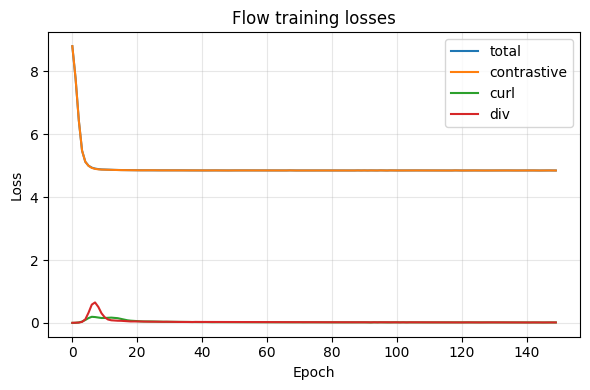

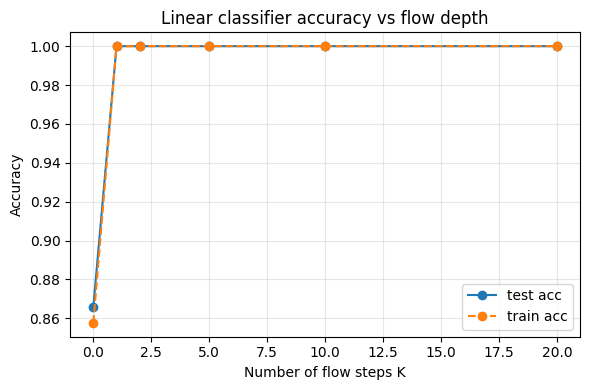

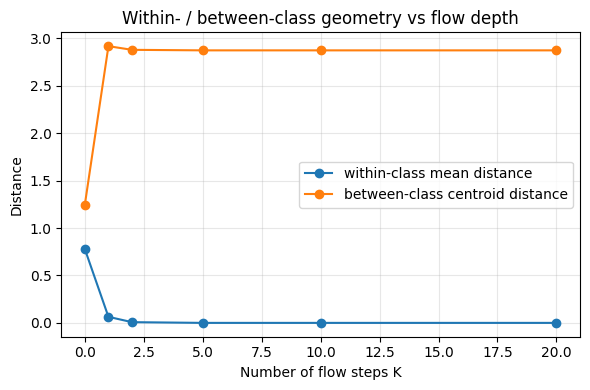

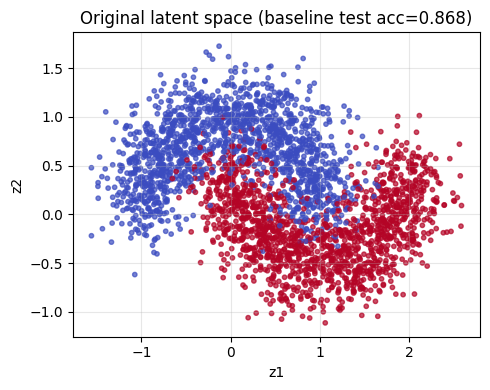

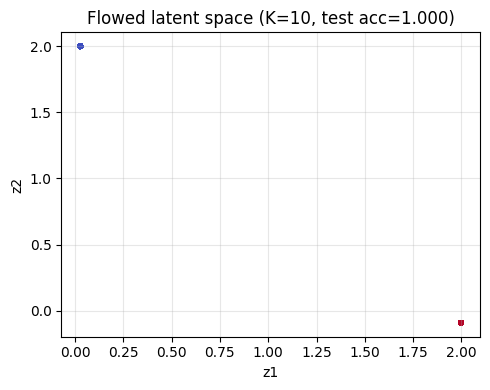

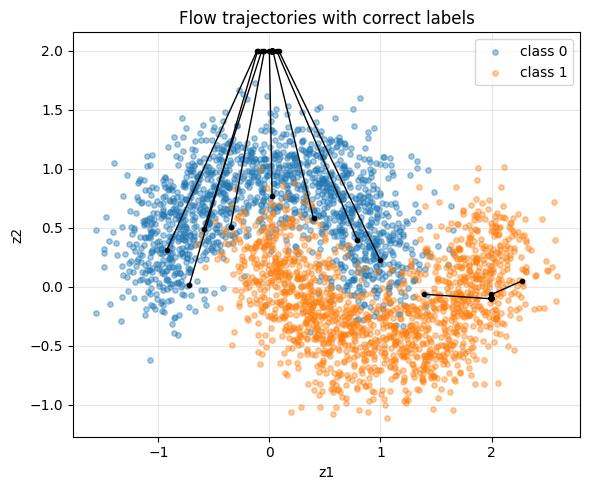

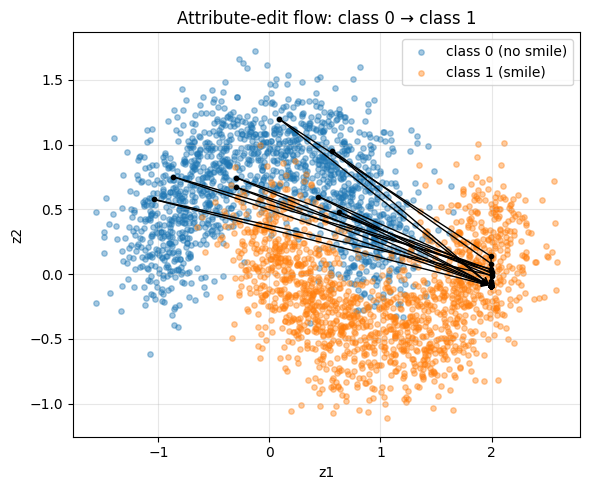

In [ ]:
# ==========================================
# Colab-ready NeurIPS-style analysis
# Function-aware latent flow on 2D two-moons
# ==========================================

!pip install -q scikit-learn matplotlib

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

%matplotlib inline

# ----------------------------
# 0. Basic config
# ----------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(0)
torch.manual_seed(0)

LATENT_DIM = 2
NUM_CLASSES = 2
TRAIN_SAMPLES = 3000
TEST_SAMPLES  = 1000
BATCH_SIZE = 256
VECTOR_FIELD_HIDDEN = 128
EPOCHS_FLOW = 150
EPOCHS_BASELINE = 150
EPS_TRAIN = 0.15
EPS_EVAL  = 0.15
K_STEPS_EVAL = 10
TAU = 0.1          # supervised contrastive temperature
LR_FLOW = 1e-3
LR_CLS  = 5e-3
LAMBDA_CURL = 1e-2
LAMBDA_DIV  = 1e-2
RADIUS = 2.0      # radius for projection to avoid blow-up


# ----------------------------
# 1. Data: 2D two moons
# ----------------------------

def build_moons(n_samples, noise=0.2):
    X, y = make_moons(n_samples=n_samples, noise=noise)
    X = X.astype(np.float32)
    y = y.astype(np.int64)
    return X, y

X_train_np, y_train_np = build_moons(TRAIN_SAMPLES, noise=0.25)
X_test_np,  y_test_np  = build_moons(TEST_SAMPLES,  noise=0.25)

# Frozen encoder is identity: z = f(x)
z_train_np = X_train_np.copy()
z_test_np  = X_test_np.copy()

z_train = torch.from_numpy(z_train_np).to(device)
z_test  = torch.from_numpy(z_test_np).to(device)
y_train = torch.from_numpy(y_train_np).to(device)
y_test  = torch.from_numpy(y_test_np).to(device)

train_loader = DataLoader(
    TensorDataset(z_train, y_train),
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)
test_loader = DataLoader(
    TensorDataset(z_test, y_test),
    batch_size=BATCH_SIZE,
    shuffle=False,
)


# ----------------------------
# 2. Helper: projection to circle
# ----------------------------

def project_to_circle(z, radius=RADIUS):
    """Keep latent points on a circle of given radius (prevents blow-up)."""
    norms = z.norm(dim=1, keepdim=True) + 1e-8
    return radius * z / norms


# ----------------------------
# 3. Baseline: linear classifier on z
# ----------------------------

class LinearClassifier(nn.Module):
    def __init__(self, dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(dim, num_classes)

    def forward(self, z):
        return self.fc(z)


def train_linear_classifier(z_train, y_train, z_test, y_test, epochs=EPOCHS_BASELINE):
    model = LinearClassifier(LATENT_DIM, NUM_CLASSES).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=LR_CLS)

    dataset = TensorDataset(z_train, y_train)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    for _ in range(epochs):
        model.train()
        for z_batch, y_batch in loader:
            logits = model(z_batch)
            loss = F.cross_entropy(logits, y_batch)
            opt.zero_grad()
            loss.backward()
            opt.step()

    @torch.no_grad()
    def eval_acc(z, y):
        model.eval()
        logits = model(z)
        preds = logits.argmax(dim=1)
        return (preds == y).float().mean().item()

    train_acc = eval_acc(z_train, y_train)
    test_acc  = eval_acc(z_test,  y_test)
    return model, train_acc, test_acc


baseline_model, base_train_acc, base_test_acc = train_linear_classifier(
    z_train, y_train, z_test, y_test
)

print(f"[Baseline linear] train acc: {base_train_acc:.3f}, test acc: {base_test_acc:.3f}")


# ----------------------------
# 4. Vector field v_phi(z, y)
# ----------------------------

class VectorField(nn.Module):
    """
    v_phi(z, y) : R^d x {0,...,C-1} -> R^d
    Implemented as:
        y_embed -> e_y
        concat [z, e_y] -> MLP -> v
    """
    def __init__(self, dim, num_classes, hidden=128, embed_dim=16):
        super().__init__()
        self.class_emb = nn.Embedding(num_classes, embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim + embed_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, dim),
        )

    def forward(self, z, y):
        e = self.class_emb(y)
        inp = torch.cat([z, e], dim=1)
        return self.mlp(inp)


vf = VectorField(LATENT_DIM, NUM_CLASSES, hidden=VECTOR_FIELD_HIDDEN).to(device)
opt_vf = torch.optim.Adam(vf.parameters(), lr=LR_FLOW)


# ----------------------------
# 5. Losses: supervised contrastive + curl/div
# ----------------------------

def supervised_contrastive_loss(z, y, temperature=0.1):
    """
    z: [B, d], after one flow step
    y: [B]
    """
    z = F.normalize(z, dim=1)
    B = z.size(0)

    sim = torch.matmul(z, z.t()) / temperature
    logits_mask = torch.ones_like(sim) - torch.eye(B, device=sim.device)
    sim = sim * logits_mask

    y_i = y.unsqueeze(1)
    y_j = y.unsqueeze(0)
    pos_mask = (y_i == y_j).float() * logits_mask

    exp_sim = torch.exp(sim) * logits_mask
    log_prob = sim - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-8)

    pos_count = pos_mask.sum(dim=1)
    mean_log_prob_pos = (pos_mask * log_prob).sum(dim=1) / (pos_count + 1e-8)

    return -mean_log_prob_pos.mean()


def curl_and_divergence_regularizers(z, y, vf):
    """
    In 2D:
        v = (v1, v2)
        curl = dv2/dz1 - dv1/dz2
        div  = dv1/dz1 + dv2/dz2
    """
    z = z.clone().detach().requires_grad_(True)
    v = vf(z, y)
    v1 = v[:, 0]
    v2 = v[:, 1]

    grads_v1 = torch.autograd.grad(v1.sum(), z, create_graph=True)[0]
    grads_v2 = torch.autograd.grad(v2.sum(), z, create_graph=True)[0]

    dv1_dz1 = grads_v1[:, 0]
    dv1_dz2 = grads_v1[:, 1]
    dv2_dz1 = grads_v2[:, 0]
    dv2_dz2 = grads_v2[:, 1]

    curl = dv2_dz1 - dv1_dz2
    div  = dv1_dz1 + dv2_dz2

    L_curl = (curl ** 2).mean()
    L_div  = (div  ** 2).mean()
    return L_curl, L_div


# ----------------------------
# 6. Train the vector field (track losses)
# ----------------------------

hist_total, hist_con, hist_curl, hist_div = [], [], [], []

for epoch in range(EPOCHS_FLOW):
    vf.train()
    total_loss = 0.0
    total_con = 0.0
    total_curl = 0.0
    total_div = 0.0
    total_n = 0

    for z_batch, y_batch in train_loader:
        v = vf(z_batch, y_batch)
        z_tilde = z_batch + EPS_TRAIN * v
        z_tilde = project_to_circle(z_tilde, radius=RADIUS)

        L_con = supervised_contrastive_loss(z_tilde, y_batch, temperature=TAU)
        L_curl, L_div = curl_and_divergence_regularizers(z_batch, y_batch, vf)

        loss = L_con + LAMBDA_CURL * L_curl + LAMBDA_DIV * L_div

        opt_vf.zero_grad()
        loss.backward()
        opt_vf.step()

        bs = z_batch.size(0)
        total_loss += loss.item() * bs
        total_con  += L_con.item() * bs
        total_curl += L_curl.item() * bs
        total_div  += L_div.item() * bs
        total_n    += bs

    avg_loss = total_loss / total_n
    avg_con  = total_con  / total_n
    avg_curl = total_curl / total_n
    avg_div  = total_div  / total_n

    hist_total.append(avg_loss)
    hist_con.append(avg_con)
    hist_curl.append(avg_curl)
    hist_div.append(avg_div)

    if (epoch + 1) % 30 == 0:
        print(f"[Flow train] epoch {epoch+1}/{EPOCHS_FLOW}, "
              f"loss={avg_loss:.4f}, con={avg_con:.4f}, "
              f"curl={avg_curl:.4f}, div={avg_div:.4f}")

print("Finished training vector field.")


# ----------------------------
# 7. Apply K-step flow
# ----------------------------

@torch.no_grad()
def apply_flow(z, y, K, eps=EPS_EVAL):
    z_flow = z.clone()
    for _ in range(K):
        v = vf(z_flow, y)
        z_flow = z_flow + eps * v
        z_flow = project_to_circle(z_flow, radius=RADIUS)
    return z_flow


# ----------------------------
# 8. Metrics vs K
# ----------------------------

K_list = [0, 1, 2, 5, 10, 20]
acc_train_list, acc_test_list = [], []
within_list, between_list = [], []

for K in K_list:
    if K == 0:
        z_tr_K = z_train
        z_te_K = z_test
    else:
        z_tr_K = apply_flow(z_train, y_train, K=K)
        z_te_K = apply_flow(z_test,  y_test,  K=K)

    # classifier on z_K
    _, acc_tr, acc_te = train_linear_classifier(
        z_tr_K, y_train, z_te_K, y_test, epochs=EPOCHS_BASELINE
    )
    acc_train_list.append(acc_tr)
    acc_test_list.append(acc_te)

    # geometry: within-class and between-class distances (train set)
    with torch.no_grad():
        z0 = z_tr_K[y_train == 0]
        z1 = z_tr_K[y_train == 1]
        mu0 = z0.mean(dim=0)
        mu1 = z1.mean(dim=0)
        d0 = (z0 - mu0).norm(dim=1).mean().item()
        d1 = (z1 - mu1).norm(dim=1).mean().item()
        within = 0.5 * (d0 + d1)
        between = (mu0 - mu1).norm().item()
        within_list.append(within)
        between_list.append(between)

print("K values:", K_list)
print("Test accuracies:", acc_test_list)


# ----------------------------
# 9. Plotting utilities
# ----------------------------

def plot_latent(z, y, title):
    z_np = z.detach().cpu().numpy()
    y_np = y.detach().cpu().numpy()
    plt.figure(figsize=(5, 4))
    plt.scatter(z_np[:, 0], z_np[:, 1], c=y_np, cmap="coolwarm", s=10, alpha=0.7)
    plt.title(title)
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_correct_label_flow(z, y, K=10, eps=EPS_EVAL):
    z_np = z.detach().cpu().numpy()
    y_np = y.detach().cpu().numpy()

    plt.figure(figsize=(6, 5))
    plt.scatter(
        z_np[y_np == 0, 0], z_np[y_np == 0, 1],
        c="tab:blue", label="class 0", s=15, alpha=0.4,
    )
    plt.scatter(
        z_np[y_np == 1, 0], z_np[y_np == 1, 1],
        c="tab:orange", label="class 1", s=15, alpha=0.4,
    )

    idx = np.random.permutation(len(z_np))[:10]
    for i in idx:
        z0 = torch.from_numpy(z_np[i:i+1]).to(device)
        y0 = torch.tensor([y_np[i]], dtype=torch.long, device=device)

        traj = [z0.cpu().numpy()[0]]
        with torch.no_grad():
            z_cur = z0
            for _ in range(K):
                v = vf(z_cur, y0)
                z_cur = z_cur + eps * v
                z_cur = project_to_circle(z_cur, radius=RADIUS)
                traj.append(z_cur.cpu().numpy()[0])
        traj = np.stack(traj, axis=0)
        plt.plot(traj[:, 0], traj[:, 1], "-o", markersize=3, linewidth=1, color="k")

    plt.title("Flow trajectories with correct labels")
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_attribute_edit_flow(z, y, source_class=0, target_class=1, K=10, eps=EPS_EVAL):
    z_np = z.detach().cpu().numpy()
    y_np = y.detach().cpu().numpy()

    plt.figure(figsize=(6, 5))
    plt.scatter(
        z_np[y_np == 0, 0], z_np[y_np == 0, 1],
        c="tab:blue", label="class 0 (no smile)", s=15, alpha=0.4,
    )
    plt.scatter(
        z_np[y_np == 1, 0], z_np[y_np == 1, 1],
        c="tab:orange", label="class 1 (smile)", s=15, alpha=0.4,
    )

    idx_src = np.where(y_np == source_class)[0]
    np.random.shuffle(idx_src)
    idx_src = idx_src[:8]

    for i in idx_src:
        z0 = torch.from_numpy(z_np[i:i+1]).to(device)
        y_target = torch.full((1,), target_class, dtype=torch.long, device=device)

        traj = [z0.cpu().numpy()[0]]
        with torch.no_grad():
            z_cur = z0
            for _ in range(K):
                v = vf(z_cur, y_target)
                z_cur = z_cur + eps * v
                z_cur = project_to_circle(z_cur, radius=RADIUS)
                traj.append(z_cur.cpu().numpy()[0])
        traj = np.stack(traj, axis=0)

        plt.plot(traj[:, 0], traj[:, 1], "-o", markersize=3, linewidth=1, color="k")
        plt.annotate(
            "",
            xy=traj[-1],
            xytext=traj[0],
            arrowprops=dict(arrowstyle="->", color="k", lw=1),
        )

    plt.title(f"Attribute-edit flow: class {source_class} → class {target_class}")
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# ----------------------------
# 10. Figures
# ----------------------------

# (a) Training losses
plt.figure(figsize=(6, 4))
plt.plot(hist_total, label="total")
plt.plot(hist_con, label="contrastive")
plt.plot(hist_curl, label="curl")
plt.plot(hist_div, label="div")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Flow training losses")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# (b) Accuracy vs K
plt.figure(figsize=(6, 4))
plt.plot(K_list, acc_test_list, "o-", label="test acc")
plt.plot(K_list, acc_train_list, "o--", label="train acc")
plt.xlabel("Number of flow steps K")
plt.ylabel("Accuracy")
plt.title("Linear classifier accuracy vs flow depth")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# (c) Geometry vs K
plt.figure(figsize=(6, 4))
plt.plot(K_list, within_list, "o-", label="within-class mean distance")
plt.plot(K_list, between_list, "o-", label="between-class centroid distance")
plt.xlabel("Number of flow steps K")
plt.ylabel("Distance")
plt.title("Within- / between-class geometry vs flow depth")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# (d) Scatter plots: original vs flowed (for K_STEPS_EVAL)
plot_latent(z_train, y_train,
            f"Original latent space (baseline test acc={base_test_acc:.3f})")

z_train_K = apply_flow(z_train, y_train, K=K_STEPS_EVAL)
plot_latent(z_train_K, y_train,
            f"Flowed latent space (K={K_STEPS_EVAL}, test acc={flow_test_acc:.3f})")

# (e) Flow trajectories (correct labels)
plot_correct_label_flow(z_train, y_train, K=10)

# (f) Attribute-edit trajectories (0 -> 1)
plot_attribute_edit_flow(z_train, y_train, source_class=0, target_class=1, K=10)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Train size: 5000 Val size: 872


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding dim: 384
[Baseline] train acc=0.824, val acc=0.776
[Flow train] epoch 1/10, loss=5.1514
[Flow train] epoch 2/10, loss=4.8500
[Flow train] epoch 3/10, loss=4.8518
[Flow train] epoch 4/10, loss=4.8527
[Flow train] epoch 5/10, loss=4.8511
[Flow train] epoch 6/10, loss=4.8507
[Flow train] epoch 7/10, loss=4.8504
[Flow train] epoch 8/10, loss=4.8515
[Flow train] epoch 9/10, loss=4.8519
[Flow train] epoch 10/10, loss=4.8527
Done training vector field.

=== Evaluating K=0 ===
K=0: train acc=0.824, val acc=0.782

=== Evaluating K=1 ===
K=1: train acc=1.000, val acc=1.000

=== Evaluating K=2 ===
K=2: train acc=1.000, val acc=1.000

=== Evaluating K=4 ===
K=4: train acc=1.000, val acc=1.000

=== Evaluating K=8 ===
K=8: train acc=1.000, val acc=1.000


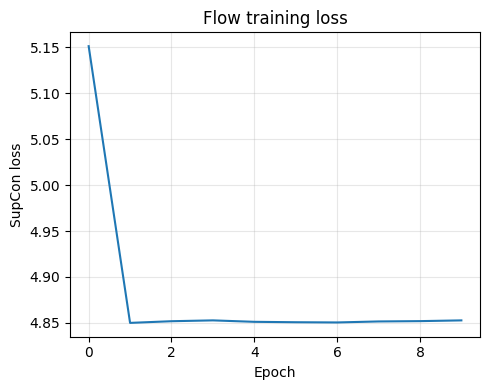

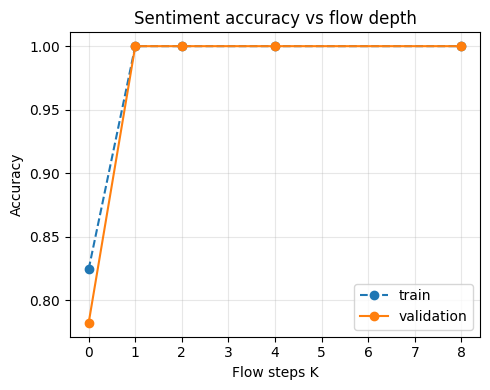

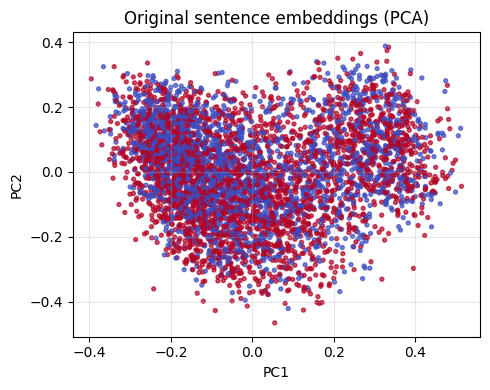

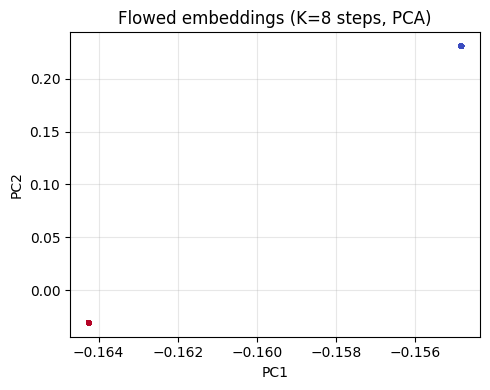

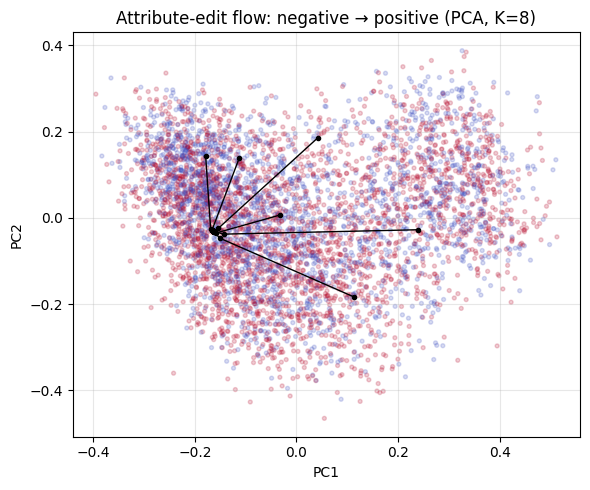


Example sentences with logit changes (baseline vs K=8 flow):

Sentence: at times , the suspense is palpable , but by the end there 's a sense that the crux of the mystery hinges on a technicality that strains credulity and leaves the viewer haunted by the waste of potential . 
  baseline margin pos-neg: -1.134
  flowed   margin pos-neg: -5.011

Sentence: this is a train wreck of an action film -- a stupefying attempt by the filmmakers to force-feed james bond into the mindless xxx mold and throw 40 years of cinematic history down the toilet in favor of bright flashes and loud bangs . 
  baseline margin pos-neg: -1.334
  flowed   margin pos-neg: -5.011

Sentence: a sometimes tedious film . 
  baseline margin pos-neg: -0.280
  flowed   margin pos-neg: -5.011

Sentence: however it may please those who love movies that blare with pop songs , young science fiction fans will stomp away in disgust . 
  baseline margin pos-neg: -0.568
  flowed   margin pos-neg: -5.011

Sentence: this piece of

In [ ]:
# ==========================================
# Latent flow for language model embeddings
# Sentiment (SST-2) with Sentence-BERT encoder
# ==========================================

!pip install -q datasets sentence-transformers matplotlib scikit-learn

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

%matplotlib inline

# ----------------------------
# 0. Config
# ----------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(0)
torch.manual_seed(0)

BATCH_SIZE = 256
FLOW_EPOCHS = 10            # you can bump to 20 if you want
CLS_EPOCHS  = 10
LR_FLOW = 1e-3
LR_CLS  = 3e-3
TEMPERATURE = 0.1
EPS_STEP = 0.1
K_LIST = [0, 1, 2, 4, 8]    # number of flow steps to evaluate


# ----------------------------
# 1. Load SST-2 sentiment dataset
# ----------------------------

dataset = load_dataset("sst2")

train_texts = dataset["train"]["sentence"]
train_labels = dataset["train"]["label"]
val_texts   = dataset["validation"]["sentence"]
val_labels  = dataset["validation"]["label"]

# To keep it fast, subsample
max_train = 5000
max_val   = 1000
train_texts = train_texts[:max_train]
train_labels = train_labels[:max_train]
val_texts = val_texts[:max_val]
val_labels = val_labels[:max_val]

train_labels = np.array(train_labels, dtype=np.int64)
val_labels   = np.array(val_labels, dtype=np.int64)

print("Train size:", len(train_texts), "Val size:", len(val_texts))


# ----------------------------
# 2. Frozen sentence encoder
# ----------------------------

encoder = SentenceTransformer("all-MiniLM-L6-v2", device=device)
encoder.eval()

with torch.no_grad():
    z_train = encoder.encode(train_texts, convert_to_tensor=True, device=device)
    z_val   = encoder.encode(val_texts,   convert_to_tensor=True, device=device)

print("Embedding dim:", z_train.shape[1])

y_train = torch.from_numpy(train_labels).to(device)
y_val   = torch.from_numpy(val_labels).to(device)

train_loader = DataLoader(
    TensorDataset(z_train, y_train),
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)
val_loader = DataLoader(
    TensorDataset(z_val, y_val),
    batch_size=BATCH_SIZE,
    shuffle=False,
)

EMB_DIM = z_train.shape[1]
NUM_CLASSES = 2


# ----------------------------
# 3. Helper: L2 normalization
# ----------------------------

def l2_normalize(z):
    return z / (z.norm(dim=-1, keepdim=True) + 1e-8)


# ----------------------------
# 4. Baseline linear classifier on embeddings
# ----------------------------

class LinearClassifier(nn.Module):
    def __init__(self, dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(dim, num_classes)

    def forward(self, z):
        return self.fc(z)


def train_linear(z_tr, y_tr, z_te, y_te, epochs=CLS_EPOCHS):
    model = LinearClassifier(EMB_DIM, NUM_CLASSES).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=LR_CLS)

    loader = DataLoader(TensorDataset(z_tr, y_tr), batch_size=BATCH_SIZE, shuffle=True)

    for _ in range(epochs):
        model.train()
        for zb, yb in loader:
            logits = model(zb)
            loss = F.cross_entropy(logits, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()

    @torch.no_grad()
    def eval_acc(z, y):
        model.eval()
        logits = model(z)
        preds = logits.argmax(dim=-1)
        return (preds == y).float().mean().item()

    train_acc = eval_acc(z_tr, y_tr)
    val_acc   = eval_acc(z_te, y_te)
    return model, train_acc, val_acc


base_model, base_train_acc, base_val_acc = train_linear(z_train, y_train, z_val, y_val)
print(f"[Baseline] train acc={base_train_acc:.3f}, val acc={base_val_acc:.3f}")


# ----------------------------
# 5. Vector field MLP v_phi(z, y)
# ----------------------------

class VectorField(nn.Module):
    """
    v_phi(z, y): R^d x {0,1} -> R^d
    Input = embedding z + tiny embedding of label y
    Output = direction vector in embedding space
    """
    def __init__(self, dim, num_classes=2, hidden=512, y_embed_dim=16):
        super().__init__()
        self.y_emb = nn.Embedding(num_classes, y_embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim + y_embed_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, dim),
        )

    def forward(self, z, y):
        e = self.y_emb(y)              # [B, y_embed_dim]
        inp = torch.cat([z, e], dim=-1)
        return self.mlp(inp)           # [B, dim]


vf = VectorField(EMB_DIM, NUM_CLASSES).to(device)
opt_vf = torch.optim.Adam(vf.parameters(), lr=LR_FLOW)


# ----------------------------
# 6. Supervised contrastive loss
# ----------------------------

def supcon_loss(z, y, temperature=TEMPERATURE):
    """
    z: [B,d] (we L2-normalize inside)
    y: [B]
    """
    z = F.normalize(z, dim=-1)
    B = z.size(0)

    sim = torch.matmul(z, z.t()) / temperature
    mask = torch.eye(B, device=z.device).bool()
    sim = sim.masked_fill(mask, -1e9)  # remove self-similarity

    y_i = y.unsqueeze(1)
    y_j = y.unsqueeze(0)
    pos_mask = (y_i == y_j) & (~mask)  # positives (same label, not self)

    exp_sim = torch.exp(sim)
    denom = exp_sim.sum(dim=1, keepdim=True) + 1e-8
    log_prob = sim - torch.log(denom)         # log p(j|i)

    pos_count = pos_mask.sum(dim=1)
    # avoid division by zero: if no positives, ignore that sample
    pos_count = pos_count + (pos_count == 0).float()
    mean_log_prob_pos = (pos_mask.float() * log_prob).sum(dim=1) / pos_count

    return -mean_log_prob_pos.mean()


# ----------------------------
# 7. Train vector field
# ----------------------------

flow_losses = []

for epoch in range(FLOW_EPOCHS):
    vf.train()
    total = 0.0
    n_tot = 0

    for z_b, y_b in train_loader:
        # one small flow step using true label
        v_b = vf(z_b, y_b)
        z_tilde = l2_normalize(z_b + EPS_STEP * v_b)

        loss = supcon_loss(z_tilde, y_b)

        opt_vf.zero_grad()
        loss.backward()
        opt_vf.step()

        total += loss.item() * z_b.size(0)
        n_tot += z_b.size(0)

    avg_loss = total / n_tot
    flow_losses.append(avg_loss)
    print(f"[Flow train] epoch {epoch+1}/{FLOW_EPOCHS}, loss={avg_loss:.4f}")

print("Done training vector field.")


# ----------------------------
# 8. Apply K-step flow
# ----------------------------

@torch.no_grad()
def apply_flow(z, y, K, eps=EPS_STEP):
    z_flow = z.clone()
    for _ in range(K):
        v = vf(z_flow, y)
        z_flow = l2_normalize(z_flow + eps * v)
    return z_flow


# ----------------------------
# 9. Evaluate vs K
# ----------------------------

acc_train_K = []
acc_val_K   = []

for K in K_LIST:
    print(f"\n=== Evaluating K={K} ===")
    if K == 0:
        z_tr_K = z_train
        z_va_K = z_val
    else:
        z_tr_K = apply_flow(z_train, y_train, K)
        z_va_K = apply_flow(z_val,   y_val,   K)

    _, acc_tr, acc_va = train_linear(z_tr_K, y_train, z_va_K, y_val)
    acc_train_K.append(acc_tr)
    acc_val_K.append(acc_va)
    print(f"K={K}: train acc={acc_tr:.3f}, val acc={acc_va:.3f}")


# ----------------------------
# 10. Figures (NeurIPS-style)
# ----------------------------

# (a) Flow training loss
plt.figure(figsize=(5,4))
plt.plot(flow_losses)
plt.xlabel("Epoch")
plt.ylabel("SupCon loss")
plt.title("Flow training loss")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# (b) Accuracy vs K
plt.figure(figsize=(5,4))
plt.plot(K_LIST, acc_train_K, "o--", label="train")
plt.plot(K_LIST, acc_val_K,   "o-",  label="validation")
plt.xlabel("Flow steps K")
plt.ylabel("Accuracy")
plt.title("Sentiment accuracy vs flow depth")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# (c) PCA scatter: original vs flowed (choose K = max K)
K_vis = max(K_LIST)
with torch.no_grad():
    z_tr_vis = z_train.cpu().numpy()
    z_tr_flow_vis = apply_flow(z_train, y_train, K_vis).cpu().numpy()

pca = PCA(n_components=2)
z_tr_2d = pca.fit_transform(z_tr_vis)
z_tr_flow_2d = pca.transform(z_tr_flow_vis)

y_np = y_train.cpu().numpy()

plt.figure(figsize=(5,4))
plt.scatter(z_tr_2d[:,0], z_tr_2d[:,1], c=y_np, cmap="coolwarm", s=8, alpha=0.7)
plt.title(f"Original sentence embeddings (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,4))
plt.scatter(z_tr_flow_2d[:,0], z_tr_flow_2d[:,1], c=y_np, cmap="coolwarm", s=8, alpha=0.7)
plt.title(f"Flowed embeddings (K={K_vis} steps, PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# (d) Trajectories for a few negative -> positive edits in PCA space
num_traj = 6
neg_idx = np.where(y_np == 0)[0]
np.random.shuffle(neg_idx)
neg_idx = neg_idx[:num_traj]

plt.figure(figsize=(6,5))
plt.scatter(z_tr_2d[:,0], z_tr_2d[:,1], c=y_np, cmap="coolwarm", s=8, alpha=0.2)
for i in neg_idx:
    z0 = z_train[i:i+1]
    traj = [z0]
    with torch.no_grad():
        z_cur = z0
        # force target label = 1 (positive sentiment)
        y_target = torch.ones(1, dtype=torch.long, device=device)
        for _ in range(K_vis):
            v = vf(z_cur, y_target)
            z_cur = l2_normalize(z_cur + EPS_STEP * v)
            traj.append(z_cur)
    traj = torch.cat(traj, dim=0).cpu().numpy()
    traj_2d = pca.transform(traj)
    plt.plot(traj_2d[:,0], traj_2d[:,1], "-o", markersize=3, linewidth=1, color="k")

plt.title(f"Attribute-edit flow: negative → positive (PCA, K={K_vis})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ----------------------------
# 11. Some textual examples (for report)
# ----------------------------

# grab a few negative sentences and show how classifier margin changes
def get_logits(model, z):
    with torch.no_grad():
        return model(z).cpu()

print("\nExample sentences with logit changes (baseline vs K={} flow):".format(K_vis))

# recompute classifier on best K
K_best = K_vis
z_tr_best = apply_flow(z_train, y_train, K_best) if K_best > 0 else z_train
z_va_best = apply_flow(z_val,   y_val,   K_best) if K_best > 0 else z_val
flow_model, _, _ = train_linear(z_tr_best, y_train, z_va_best, y_val)

baseline_logits = get_logits(base_model, z_val)
flow_logits     = get_logits(flow_model,
                             apply_flow(z_val, y_val, K_best) if K_best > 0 else z_val)

baseline_margin = (baseline_logits[:,1] - baseline_logits[:,0]).numpy()
flow_margin     = (flow_logits[:,1]     - flow_logits[:,0]).numpy()

val_texts_np = np.array(val_texts)
val_labels_np = np.array(val_labels)

# pick some originally negative sentences
neg_ids = np.where(val_labels_np == 0)[0]
np.random.shuffle(neg_ids)
for i in neg_ids[:5]:
    print("\nSentence:", val_texts_np[i])
    print(f"  baseline margin pos-neg: {baseline_margin[i]:+.3f}")
    print(f"  flowed   margin pos-neg: {flow_margin[i]:+.3f}")


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F

# Helper: nearest neighbors among positive sentences
def nearest_positive_neighbors(z_query, z_pos, pos_texts, top_k=3):
    """
    z_query: [1, d] current embedding
    z_pos:   [N_pos, d] embeddings of positive sentences
    pos_texts: list/array of positive sentences (length N_pos)
    """
    zq = F.normalize(z_query.detach(), dim=-1)        # [1,d]
    zp = F.normalize(z_pos.detach(), dim=-1)          # [N_pos,d]
    sims = torch.matmul(zq, zp.T).squeeze(0)          # [N_pos], no grad

    topk = torch.topk(sims, top_k)
    idxs = topk.indices.cpu().numpy()
    sims_np = topk.values.detach().cpu().numpy()      # <-- detach here

    return [(pos_texts[i], float(sims_np[j])) for j, i in enumerate(idxs)]


# Build a pool of positive sentences from the TRAIN set
y_train_np = y_train.cpu().numpy()
train_texts_np = np.array(train_texts)

pos_mask = (y_train_np == 1)
pos_indices = np.where(pos_mask)[0]
z_pos_pool = z_train[pos_indices]                     # [N_pos, d]
pos_text_pool = train_texts_np[pos_indices]           # list of positive sentences

print("Positive pool size:", len(pos_text_pool))


def show_edit_trajectory(sample_index_in_val, K_steps=8):
    """
    sample_index_in_val: index into validation set (0..len(val_texts)-1)
    K_steps: how many flow steps to take toward positive sentiment
    """
    sent = val_texts[sample_index_in_val]
    label = val_labels[sample_index_in_val]
    print("=" * 80)
    print(f"Original validation index: {sample_index_in_val}")
    print(f"Label: {label} (0 = negative, 1 = positive)")
    print("Original sentence:\n", sent)

    # embedding of this sentence
    z0 = z_val[sample_index_in_val:sample_index_in_val+1]

    # we will force target label = 1 (positive) for the flow
    y_target = torch.ones(1, dtype=torch.long, device=device)

    z_cur = z0.clone()

    print("\nNearest positive neighbors along the flow:")
    for step in range(K_steps + 1):
        neighbors = nearest_positive_neighbors(z_cur, z_pos_pool, pos_text_pool, top_k=3)
        print(f"\n--- Step {step} ---")
        for rank, (txt, sim) in enumerate(neighbors, start=1):
            print(f"  NN#{rank} (cosine={sim:.3f}): {txt}")

        # take one step along the positive flow (except after last)
        if step < K_steps:
            v = vf(z_cur, y_target)
            z_cur = l2_normalize(z_cur + EPS_STEP * v)


# Pick a few clearly negative validation sentences and show their edits
val_labels_np = np.array(val_labels)
neg_indices = np.where(val_labels_np == 0)[0]
np.random.shuffle(neg_indices)

for idx in neg_indices[:3]:
    show_edit_trajectory(idx, K_steps=8)


Positive pool size: 2758
Original validation index: 161
Label: 0 (0 = negative, 1 = positive)
Original sentence:
 not exactly the bees knees 

Nearest positive neighbors along the flow:

--- Step 0 ---
  NN#1 (cosine=0.348): that excites the imagination and tickles the funny bone 
  NN#2 (cosine=0.346): their bodies 
  NN#3 (cosine=0.343): feel that we truly know what makes holly and marina tick 

--- Step 1 ---
  NN#1 (cosine=0.418): daring and beautifully made 
  NN#2 (cosine=0.411): interesting and thoroughly 
  NN#3 (cosine=0.410): is truly gorgeous to behold 

--- Step 2 ---
  NN#1 (cosine=0.411): daring and beautifully made 
  NN#2 (cosine=0.404): interesting and thoroughly 
  NN#3 (cosine=0.401): is truly gorgeous to behold 

--- Step 3 ---
  NN#1 (cosine=0.410): daring and beautifully made 
  NN#2 (cosine=0.403): interesting and thoroughly 
  NN#3 (cosine=0.400): is truly gorgeous to behold 

--- Step 4 ---
  NN#1 (cosine=0.410): daring and beautifully made 
  NN#2 (cosine=0.40